[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mengyulin/CoastalEngineering/blob/master/Showcase/Chap_4/1_StokesWaves.ipynb)

## 載入 Python 函式庫

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

In [2]:
from ipywidgets import interact

## 載入 Waves 模組 (求解頻散關係式)

In [3]:
class Waves:
    r"""
    Solves the wave dispersion relationship via Newton-Raphson.

    .. math::
        \omega^2 = gk\tanh kh

    Parameters
    ----------
    h : array_like, str
        Water depth [m] or 'deep', 'shallow' as keywords
    T : array_like
        Wave period [s]
    L : array_like
        Wave length [m]
    thetao : array_like
        TODO
    Ho : array_like
        TODO

    Returns
    -------
    omega : array_like
            Wave frequency
    TODO: hoLo, hoL, Lo, L, k, T, Co, C, Cg, G, Ks, Kr, theta, H

    Notes
    -----
    Compare values with:
    http://www.coastal.udel.edu/faculty/rad/wavetheory.html

    Examples
    --------
    >>> from oceans.sw_extras.waves import Waves
    >>> wav = Waves(h=10, T=5, L=None)
    >>> print(f"ho/Lo = {wav.hoLo:.3f}")
    ho/Lo = 0.256
    >>> print(f"ho/L  = {wav.hoL:.3f}")
    ho/L  = 0.273
    >>> print(f"Lo    = {wav.Lo:.3f}")
    Lo    = 39.033
    >>> print(f"L     = {wav.L:.3f}")
    L     = 36.593
    >>> print(f"k     = {wav.k:.3f}")
    k     = 0.172
    >>> print(f"omega = {wav.omega:.3f}")
    omega = 1.257
    >>> print(f"T     = {wav.T:.3f}")
    T     = 5.000
    >>> print(f"C     = {wav.C:.3f}")
    C     = 7.319
    >>> print(f"Cg    = {wav.Cg:.3f}")
    Cg    = 4.471
    >>> print(f"G     = {wav.G:.3f}")
    G     = 0.222
    >>> wav = Waves(h=10, T=None, L=100)
    >>> print(f"ho/Lo = {wav.hoLo:.3f}")
    ho/Lo = 0.056
    >>> print(f"ho/L  = {wav.hoL:.3f}")
    ho/L  = 0.100
    >>> print(f"Lo    = {wav.Lo:.3f}")
    Lo    = 179.568
    >>> print(f"L     = {wav.L:.3f}")
    L     = 100.000
    >>> print(f"k     = {wav.k:.3f}")
    k     = 0.063
    >>> print(f"omega = {wav.omega:.3f}")
    omega = 0.586
    >>> print(f"T     = {wav.T:.3f}")
    T     = 10.724
    >>> print(f"C     = {wav.C:.3f}")
    C     = 9.325
    >>> print(f"Cg    = {wav.Cg:.3f}")
    Cg    = 8.291
    >>> print(f"G     = {wav.G:.3f}")
    G     = 0.778
    >>> print(f"Ks  = {wav.Ks:.3f}")
    Ks  = 1.005

    """

    def __init__(self, h, T=None, L=None, thetao=None, Ho=None, lat=None):
        self.T = np.asarray(T, dtype=np.float64)
        self.L = np.asarray(L, dtype=np.float64)
        self.Ho = np.asarray(Ho, dtype=np.float64)
        self.lat = np.asarray(lat, dtype=np.float64)
        self.thetao = np.asarray(thetao, dtype=np.float64)

        if isinstance(h, str):
            if L is not None:
                if h == "deep":
                    self.h = self.L / 2.0
                elif h == "shallow":
                    self.h = self.L * 0.05
        else:
            self.h = np.asarray(h, dtype=np.float64)

        g = 9.81  # Default gravity.

        if L is None:
            self.omega = 2 * np.pi / self.T
            self.Lo = (g * self.T**2) / 2 / np.pi
            # Returns wavenumber of the gravity wave dispersion relation using
            # newtons method. The initial guess is shallow water wavenumber.
            self.k = self.omega / np.sqrt(g)
            # TODO: May change to,
            # self.k = self.w ** 2 / (g * np.sqrt(self.w ** 2 * self.h / g))
            f = g * self.k * np.tanh(self.k * self.h) - self.omega**2

            while np.abs(f.max()) > 1e-10:
                dfdk = g * self.k * self.h * (
                    1 / (np.cosh(self.k * self.h))
                ) ** 2 + g * np.tanh(self.k * self.h)
                self.k = self.k - f / dfdk
                # FIXME:
                f = g * self.k * np.tanh(self.k * self.h) - self.omega**2

            self.L = 2 * np.pi / self.k
            if isinstance(h, str):
                if h == "deep":
                    self.h = self.L / 2.0
                elif h == "shallow":
                    self.h = self.L * 0.05
        else:
            self.Lo = self.L / np.tanh(2 * np.pi * self.h / self.L)
            self.k = 2 * np.pi / self.L
            self.T = np.sqrt(2 * np.pi * self.Lo / g)
            self.omega = 2 * np.pi / self.T

        self.hoL = self.h / self.L
        self.hoLo = self.h / self.Lo
        self.C = self.omega / self.k  # or L / T
        self.Co = self.Lo / self.T
        self.G = 2 * self.k * self.h / np.sinh(2 * self.k * self.h)
        self.n = (1 + self.G) / 2
        self.Cg = self.n * self.C
        self.Ks = np.sqrt(1 / (1 + self.G) / np.tanh(self.k * self.h))

        if thetao is None:
            self.theta = np.NaN
            self.Kr = np.NaN
        if thetao is not None:
            self.theta = np.rad2deg(
                np.asin(self.C / self.Co * np.sin(np.deg2rad(self.thetao))),
            )
            self.Kr = np.sqrt(
                np.cos(np.deg2rad(self.thetao)) / np.cos(np.deg2rad(self.theta)),
            )

        if Ho is None:
            self.H = np.NaN
        if Ho is not None:
            self.H = self.Ho * self.Ks * self.Kr

# Stokes Waves

## 波形函數

Stokes 理論二階解之水面波形
\begin{align}
\eta = &\frac{H}{2}\cos (kx-\omega t)\nonumber\\
\label{eq:2}
&+\frac{\pi H}{8}\left(\frac{H}{L}\right)\frac{\cosh kh(2+\cosh 2kh)}{\sinh^{3} kh}\cos 2(kx-\omega t)
\end{align}
其中
* $H$: 波高
* $k = 2\pi/L$: 波數
* $L$: 波長
* $\omega = 2\pi/T$: 角頻率
* $T$: 波週期

## 不同波高之水面波形

週期 7 s 的水波，水深為 30 m。

In [4]:
T = 7.0
h = 30.0
wav = Waves(h=10, T=5, L=None)
k = wav.k
L = wav.L
x = np.linspace(0, 2*L, 500)


def myplot(H=1):
    y = (H/2) * np.cos(k*x) + (np.pi*H/8)*(H/L)*((np.cosh(k*h)*(2+np.cosh(2*k*h)))/(np.sinh(k*h))**3)*np.cos(2*k*x)
    plt.plot(x, y/H)
    plt.xlabel("x")
    plt.ylabel("$\eta/H$")
    plt.ylim(-1.0, 1.0)
    major_ticks = np.arange(-1, 2, 1)
    plt.yticks(major_ticks)
    plt.grid(axis='y')
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.rcParams['figure.dpi'] = 100

In [5]:
interact(myplot, H=(1., 15.))

interactive(children=(FloatSlider(value=1.0, description='H', max=15.0, min=1.0), Output()), _dom_classes=('wi…

<function __main__.myplot(H=1)>

In [6]:
6/L

0.16396413862706075

In [7]:
h/L

0.8198206931353037

## 水粒子軌跡

\begin{align}
x = &x_1 -\frac{H}{2}\frac{\cosh k(h+z_1)}{\sinh kh}\sin(kx_1-\omega t)\nonumber\\
&+\frac{\pi H^{2}}{8L\sinh^{2}(kh)}\left(1-\frac{3\cosh 2k(h+z_1)}{2\sinh^{2}(kh)}
\right)\sin 2(kx_1-\omega t)\nonumber\\
&+\frac{\pi H^{2}}{4L}\frac{\cosh 2k(h+z_1)}{\sinh^{2}(kh)}\omega t
\end{align}
\begin{align}
z = &z_1 + \frac{H}{2}\frac{\sinh k(h+z_1)}{\sinh kh}\cos (kx_1-\omega t)\nonumber\\
\label{eq:12}
&+\frac{3\pi H^{2}}{16L}\frac{\sinh 2k(h+z_1)}{\sinh^{4}(kh)}\cos 2(kx_1-\omega t)
\end{align}


### 水粒子軌跡座標函式

In [8]:
def StokesParticleTrajectory(x1,z1,t):
    x = x1 - H/2 * np.cosh(k*(h+z1))/np.sinh(k*h) * np.sin(k*x1-omega*t) \
    + (np.pi*H**2)/(8*L*(np.sinh(k*h))**2)*(1-(2*np.cosh(2*k*(h+z1)))/(2*(np.sinh(k*h))**2))*np.sin(k*x1-omega*t) \
    + (np.pi*H**2)/(4*L)*(np.cosh(2*k*(h+z1)))/(np.sinh(k*h))**2*omega*t
    z = z1 + H/2 * np.sinh(k*(h+z1))/np.sinh(k*h) * np.cos(k*x1-omega*t) \
    + (3*np.pi*H**2)/(16*L)*(np.sinh(2*k*(h+z1)))/(np.sinh(k*h))**4 * np.cos(2*(k*x1-omega*t))
    
    return x, z

### 水面波形

In [9]:
def eta(x,t):
    return (H/2) * np.cos(k*x-omega*t) + (np.pi*H/8)*(H/L)*((np.cosh(k*h)*(2+np.cosh(2*k*h))) \
                                                            /(np.sinh(k*h))**3)*np.cos(2*(k*x-omega*t))

一個波高 6 m 高、週期 7 s 的水波，水深為 30 m。

In [10]:
H = 6                           # wave height
h = 30                          # water depth
T = 7                           # wave period
omega = 2*np.pi/T               # angular frequency
wav = Waves(h, T, L=None)       # class Waves
k = wav.k                       # wave number
L = wav.L                       # wavelength

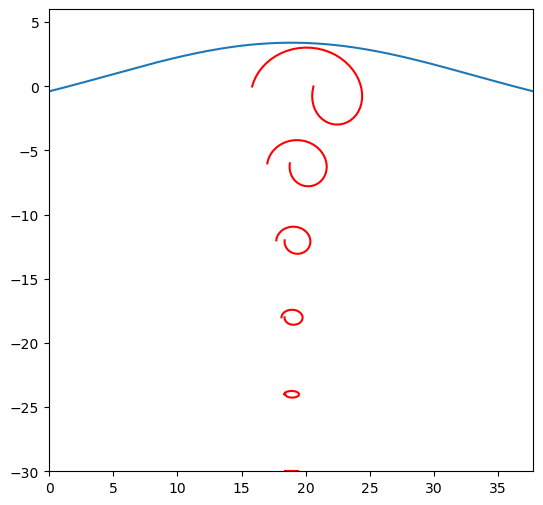

In [11]:
t = np.linspace(0, T, 50)
x1 = L/4
z1 = np.linspace(-h, 0, 6)

# Set figure
fig4, ax4 = plt.subplots(figsize=(15,6))
ax4.set_aspect("equal")
ax4.set_xlim(0,L/2)
ax4.set_ylim(-h,H)

for z2 in z1:
    XT, ZT = StokesParticleTrajectory(x1,z2,t)
    PT = ax4.plot(XT,ZT,'r')

# Plot free surface
FS4 = ax4.plot(x,eta(x,T/4))